In [1]:
import sys
import os
import random
import math
import time
import torch

In [2]:
torch.utils.backcompat.broadcast_warning.enabled = True
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
import torch.backends.cudnn as cudnn;

In [3]:
cudnn.benchmark = True
from scipy.fftpack import fft, rfft, fftfreq, irfft, ifft, rfftfreq
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import *

In [4]:
import torch
splits_by_image_file = torch.load('block_splits_by_image.pth')
eeg_data_file = torch.load('eeg_dataset.pth')

In [7]:
class EEGDataset:

    def __init__(self):
        
        loaded = eeg_data_file
        self.data = loaded["dataset"]
        self.labels = loaded["labels"]
        self.images = loaded["images"]
        self.means = loaded["means"]
        self.stddevs = loaded["stddevs"]
        # Compute size
        self.size = len(self.data)

    # Get size
    def __len__(self):
        return self.size

    # Get item
    def __getitem__(self, i):
        # Process EEG
        eeg = ((self.data[i]["eeg"].float() - self.means) / self.stddevs)  # .t() # CxT
        eeg = eeg.t()
        eeg = eeg[20:450, :]  # Making all tensors shape=(430,128)
        # Get label
        label = self.data[i]["label"]
        # Return
        return eeg, label


# Splitter class
class Splitter:

    def __init__(self, dataset, split_path, split_num=0, split_name="train"):
        # Set EEG dataset
        self.dataset = dataset
        # Load split
        loaded = splits_by_image_file
        self.split_idx = loaded["splits"][split_num][split_name]
        # Filter data
        self.split_idx = [i for i in self.split_idx if 450 <= self.dataset.data[i]["eeg"].size(1) <= 600]
        # Compute size
        self.size = len(self.split_idx)

    # Get size
    def __len__(self):
        return self.size

    # Get item
    def __getitem__(self, i):
        # Get sample from dataset
        eeg, label = self.dataset[self.split_idx[i]]
        # Return
        return eeg, label

In [8]:
class EncoderModel(nn.Module):

    def __init__(self, input_size, lstm_size, lstm_layers, embedding_size, num_classes):
        # Call parent
        super().__init__()
        # Define parameters
        self.input_size = input_size
        self.lstm_size = lstm_size
        self.lstm_layers = lstm_layers
        self.embedding_size = embedding_size
        self.num_classes = num_classes
        # Define internal modules
        self.lstm = nn.LSTM(input_size, lstm_size, num_layers=lstm_layers, batch_first=True)
        self.embedding = nn.Linear(lstm_size, embedding_size)
        self.classifier = nn.Linear(embedding_size, num_classes)

    def forward(self, x):
        # Forward LSTM and get final state
        x = self.lstm(x)[0][:, -1, :]
        # Forward embedding
        emb = F.relu(self.embedding(x))
        # Forward classifier
        x = self.classifier(emb)
        return x

In [9]:
# Load dataset
dataset = EEGDataset()
# Create loaders
mini_batch = 16
loaders = {split: DataLoader(Splitter(dataset, split_path=splits_by_image_file, split_num=0, split_name=split), batch_size=mini_batch, drop_last=True, shuffle=True) for split in ["train", "val", "test"]}

In [10]:
def train(epochs, printLossesAtEpoch, lstm_units, lstm_layers, embedding_size, num_classes, mini_batch):
    model = EncoderModel(128, lstm_units, lstm_layers, embedding_size, num_classes)  
    optimizer = getattr(torch.optim, "Adam")(model.parameters(), lr=0.001)
  
  
    # Set up arrays to use to store performance
    trLoss = np.array([])
    vaLoss = np.array([])
  
  
    # Start training
    for epoch in range(1, epochs + 1):
        # Initialize loss/accuracy variables
        losses = {"train": 0, "val": 0, "test": 0}
        accuracies = {"train": 0, "val": 0, "test": 0}
        counts = {"train": 0, "val": 0, "test": 0}
        # Process each split
        for split in ("train", "val", "test"):
            #Set network mode
            if split == "train":
                model.train()
                torch.set_grad_enabled(True)
            else:
                model.eval()
                torch.set_grad_enabled(False)
            # Process all split batches
            for i, (input, target) in enumerate(loaders[split]):
                # Forward
                output = model(input)
                loss = F.cross_entropy(output, target)
                losses[split] += loss.item()
                # Compute accuracy
                _, pred = output.data.max(1)
                correct = pred.eq(target.data).sum().item()
                accuracy = correct / input.data.size(0)
                accuracies[split] += accuracy
                counts[split] += 1
                # Backward and optimize
                if split == "train":
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
        # Print info at the end of the epoch
        print("Epoch {0}: TrL={1:.4f}, TrA={2:.4f}, VL={3:.4f}, VA={4:.4f}, TeL={5:.4f}, TeA={6:.4f}".format(epoch,
                                                                                                           losses[
                                                                                                               "train"] /
                                                                                                           counts[
                                                                                                               "train"],
                                                                                                           accuracies[
                                                                                                               "train"] /
                                                                                                           counts[
                                                                                                               "train"],
                                                                                                           losses["val"] /
                                                                                                           counts["val"],
                                                                                                           accuracies[
                                                                                                               "val"] /
                                                                                                           counts["val"],
                                                                                                           losses[
                                                                                                               "test"] /
                                                                                                           counts["test"],
                                                                                                           accuracies[
                                                                                                               "test"] /
                                                                                                           counts[
                                                                                                               "test"]))
        # Now add the training loss, val loss and epoch to an np array
        trLoss = np.append(trLoss, losses["train"] / counts["train"])
        vaLoss = np.append(vaLoss, losses["val"] / counts["val"])
        numEpochs = trLoss.shape[0]
        epochsToPlot = np.linspace(1, numEpochs, numEpochs)

      
      
        # save the model 
        PATH = "D:\\Ruchi\\Thesis\\work\\EEG-RSVP\\Embedding the EEG\\encoder_model_1.pth"
        torch.save(model.state_dict(), PATH)
      
      
      
        # Print the loss vs epoch graph

        if epoch % printLossesAtEpoch == 0:
            print("Performance:")
            plot(epochsToPlot, trLoss, label='Training Loss')
            plot(epochsToPlot, vaLoss, label='Validation Loss')
            legend()
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.savefig('figureSaved_lstmLays2_attempt3.png')
            plt.show()
          
    PATH = 'D:\\Ruchi\\Thesis\\work\\EEG-RSVP\\Embedding the EEG\\encoder_model_1.pth'
    torch.save(model.state_dict(), PATH)

Epoch 1: TrL=2.8470, TrA=0.1671, VL=2.2273, VA=0.2636, TeL=2.2035, TeA=0.2712
Epoch 2: TrL=1.7928, TrA=0.3912, VL=1.5588, VA=0.4703, TeL=1.5340, TeA=0.4733
Epoch 3: TrL=1.3800, TrA=0.5299, VL=1.3394, VA=0.5413, TeL=1.3134, TeA=0.5565
Epoch 4: TrL=1.1364, TrA=0.6284, VL=1.2410, VA=0.5756, TeL=1.2168, TeA=0.5811
Epoch 5: TrL=1.0204, TrA=0.6554, VL=0.9574, VA=0.6799, TeL=0.9508, TeA=0.6870
Epoch 6: TrL=0.7219, TrA=0.7544, VL=0.7742, VA=0.7334, TeL=0.6883, TeA=0.7692
Epoch 7: TrL=0.6058, TrA=0.7999, VL=0.7236, VA=0.7535, TeL=0.7161, TeA=0.7692
Epoch 8: TrL=0.5910, TrA=0.8096, VL=0.8171, VA=0.7394, TeL=0.8280, TeA=0.7470
Epoch 9: TrL=0.4328, TrA=0.8556, VL=0.6557, VA=0.7923, TeL=0.6406, TeA=0.8009
Epoch 10: TrL=0.4078, TrA=0.8673, VL=0.4798, VA=0.8397, TeL=0.4695, TeA=0.8412
Epoch 11: TrL=0.3164, TrA=0.8965, VL=0.4355, VA=0.8634, TeL=0.4477, TeA=0.8679
Epoch 12: TrL=0.3077, TrA=0.9009, VL=0.3665, VA=0.8780, TeL=0.3241, TeA=0.8861
Epoch 13: TrL=0.3989, TrA=0.8781, VL=0.5014, VA=0.8407, TeL=0

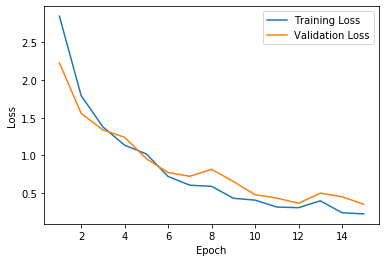

Epoch 16: TrL=0.2664, TrA=0.9139, VL=0.4389, VA=0.8690, TeL=0.4280, TeA=0.8624
Epoch 17: TrL=0.1800, TrA=0.9409, VL=0.4681, VA=0.8604, TeL=0.4634, TeA=0.8634
Epoch 18: TrL=0.1567, TrA=0.9516, VL=0.2951, VA=0.9083, TeL=0.3187, TeA=0.9088
Epoch 19: TrL=0.1707, TrA=0.9468, VL=0.2917, VA=0.9118, TeL=0.3472, TeA=0.8947
Epoch 20: TrL=0.1363, TrA=0.9569, VL=0.3030, VA=0.9032, TeL=0.3176, TeA=0.9103
Epoch 21: TrL=0.1523, TrA=0.9525, VL=0.4257, VA=0.8619, TeL=0.4082, TeA=0.8705
Epoch 22: TrL=0.1826, TrA=0.9448, VL=0.3026, VA=0.9057, TeL=0.2808, TeA=0.9229
Epoch 23: TrL=0.1697, TrA=0.9521, VL=0.2975, VA=0.9057, TeL=0.3152, TeA=0.9012
Epoch 24: TrL=0.1474, TrA=0.9499, VL=0.3066, VA=0.9052, TeL=0.3335, TeA=0.8992
Epoch 25: TrL=0.2204, TrA=0.9320, VL=0.5758, VA=0.8276, TeL=0.5709, TeA=0.8382
Epoch 26: TrL=0.1803, TrA=0.9415, VL=0.4699, VA=0.8720, TeL=0.5645, TeA=0.8584
Epoch 27: TrL=0.1395, TrA=0.9579, VL=0.2290, VA=0.9269, TeL=0.2892, TeA=0.9123
Epoch 28: TrL=0.1109, TrA=0.9650, VL=0.2515, VA=0.93

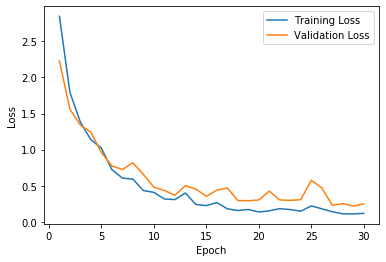

Epoch 31: TrL=0.0929, TrA=0.9716, VL=0.1996, VA=0.9430, TeL=0.2107, TeA=0.9400
Epoch 32: TrL=0.1247, TrA=0.9591, VL=0.2533, VA=0.9219, TeL=0.2670, TeA=0.9214
Epoch 33: TrL=0.1265, TrA=0.9625, VL=0.6737, VA=0.8538, TeL=0.7001, TeA=0.8533
Epoch 34: TrL=0.1602, TrA=0.9532, VL=0.2748, VA=0.9229, TeL=0.2722, TeA=0.9224
Epoch 35: TrL=0.0443, TrA=0.9879, VL=0.1767, VA=0.9491, TeL=0.2071, TeA=0.9405
Epoch 36: TrL=0.0738, TrA=0.9772, VL=0.1904, VA=0.9446, TeL=0.2171, TeA=0.9410
Epoch 37: TrL=0.0697, TrA=0.9781, VL=0.3214, VA=0.9143, TeL=0.3193, TeA=0.9178
Epoch 38: TrL=0.1079, TrA=0.9702, VL=0.2798, VA=0.9234, TeL=0.2982, TeA=0.9168
Epoch 39: TrL=0.0837, TrA=0.9738, VL=0.2190, VA=0.9420, TeL=0.2350, TeA=0.9375
Epoch 40: TrL=0.0864, TrA=0.9741, VL=0.2759, VA=0.9173, TeL=0.3216, TeA=0.9138
Epoch 41: TrL=0.0948, TrA=0.9721, VL=0.3571, VA=0.9037, TeL=0.3838, TeA=0.8977
Epoch 42: TrL=0.0902, TrA=0.9755, VL=0.4428, VA=0.8896, TeL=0.4998, TeA=0.8831
Epoch 43: TrL=0.1062, TrA=0.9681, VL=0.2035, VA=0.93

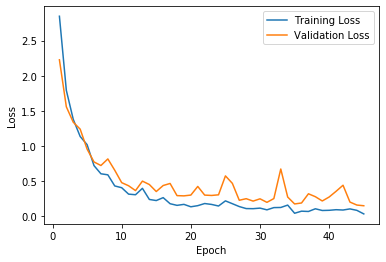

Epoch 46: TrL=0.0424, TrA=0.9896, VL=0.1828, VA=0.9461, TeL=0.2002, TeA=0.9420
Epoch 47: TrL=0.0935, TrA=0.9725, VL=0.3328, VA=0.9128, TeL=0.3221, TeA=0.9173
Epoch 48: TrL=0.1096, TrA=0.9647, VL=0.2417, VA=0.9299, TeL=0.2722, TeA=0.9284
Epoch 49: TrL=0.0518, TrA=0.9845, VL=0.2474, VA=0.9320, TeL=0.2684, TeA=0.9249
Epoch 50: TrL=0.0485, TrA=0.9854, VL=0.2496, VA=0.9380, TeL=0.3271, TeA=0.9239
Epoch 51: TrL=0.0790, TrA=0.9772, VL=0.2325, VA=0.9395, TeL=0.2911, TeA=0.9209
Epoch 52: TrL=0.0542, TrA=0.9850, VL=0.2935, VA=0.9269, TeL=0.3936, TeA=0.9118
Epoch 53: TrL=0.0997, TrA=0.9720, VL=0.2214, VA=0.9410, TeL=0.2735, TeA=0.9294
Epoch 54: TrL=0.0818, TrA=0.9776, VL=0.1762, VA=0.9481, TeL=0.2164, TeA=0.9390
Epoch 55: TrL=0.0599, TrA=0.9830, VL=0.1749, VA=0.9506, TeL=0.1816, TeA=0.9521
Epoch 56: TrL=0.0371, TrA=0.9893, VL=0.1855, VA=0.9551, TeL=0.1940, TeA=0.9546
Epoch 57: TrL=0.0131, TrA=0.9961, VL=0.1381, VA=0.9627, TeL=0.1471, TeA=0.9642
Epoch 58: TrL=0.0192, TrA=0.9946, VL=0.1880, VA=0.94

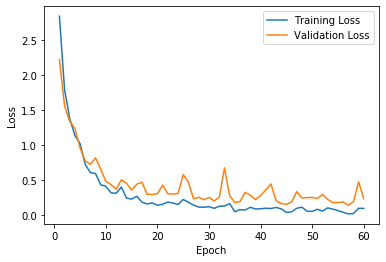

In [11]:
train(epochs=60, printLossesAtEpoch=15, lstm_units=128, lstm_layers=1, embedding_size=126, num_classes=40, mini_batch=mini_batch)

In [12]:
class ModifiedEncoderModel(nn.Module):

    def __init__(self, input_size, lstm_size, lstm_layers, embedding_size, num_classes):
        # Call parent
        super().__init__()
        # Define parameters
        self.input_size = input_size
        self.lstm_size = lstm_size
        self.lstm_layers = lstm_layers
        self.embedding_size = embedding_size
        self.num_classes = num_classes
        # Define internal modules
        self.lstm = nn.LSTM(input_size, lstm_size, num_layers=lstm_layers, batch_first=True)
        self.embedding = nn.Linear(lstm_size, embedding_size)
        self.classifier = nn.Linear(embedding_size, num_classes)

    def forward(self, x):
        # Prepare LSTM initiale state
        batch_size = x.size(0)
        # Forward LSTM and get final state
        x = self.lstm(x)[0][:, -1, :]
        # Forward embedding
        emb = F.relu(self.embedding(x))
        EEG_emb_tot_np[label] = np.add(EEG_emb_tot_np[label], emb.detach().numpy())
        # Forward classifier
        x = self.classifier(emb)
        return x

In [13]:
classifier = ModifiedEncoderModel(128, 128, 1, 126, 40) 
classifier.load_state_dict(torch.load('D:\\Ruchi\\Thesis\\work\\EEG-RSVP\\Embedding the EEG\\encoder_model_1.pth'))
classifier.eval()

ModifiedEncoderModel(
  (lstm): LSTM(128, 128, batch_first=True)
  (embedding): Linear(in_features=128, out_features=126, bias=True)
  (classifier): Linear(in_features=126, out_features=40, bias=True)
)

In [14]:
classes = np.array([])

# Array to store the totals for each class
EEG_emb_tot_np = np.zeros(shape=(40,126))



for i in range(11965):
    #get point
    eeg_point, label = dataset.__getitem__(i)
    #predict
    eeg_point = eeg_point.unsqueeze(0)
    output = classifier(eeg_point)
    pred = output.max(1).indices.numpy()[0]

    classes = np.append(classes, label)

    
# Get a tuple of unique values & their frequency in numpy array
uniqueValues, occurCount = np.unique(classes, return_counts=True)
 
# Zip both the arrays
listOfUniques = zip(uniqueValues, occurCount)
 
print('Unique Values along with occurrence Count')
# Iterate over the zip object
for elem in listOfUniques:
    print(elem[0] , ' Occurs : ' , elem[1], ' times')

Unique Values along with occurrence Count
0.0  Occurs :  300  times
1.0  Occurs :  300  times
2.0  Occurs :  300  times
3.0  Occurs :  300  times
4.0  Occurs :  300  times
5.0  Occurs :  300  times
6.0  Occurs :  300  times
7.0  Occurs :  300  times
8.0  Occurs :  300  times
9.0  Occurs :  300  times
10.0  Occurs :  300  times
11.0  Occurs :  300  times
12.0  Occurs :  300  times
13.0  Occurs :  300  times
14.0  Occurs :  300  times
15.0  Occurs :  300  times
16.0  Occurs :  300  times
17.0  Occurs :  300  times
18.0  Occurs :  294  times
19.0  Occurs :  300  times
20.0  Occurs :  300  times
21.0  Occurs :  300  times
22.0  Occurs :  300  times
23.0  Occurs :  300  times
24.0  Occurs :  300  times
25.0  Occurs :  294  times
26.0  Occurs :  294  times
27.0  Occurs :  300  times
28.0  Occurs :  300  times
29.0  Occurs :  300  times
30.0  Occurs :  300  times
31.0  Occurs :  300  times
32.0  Occurs :  300  times
33.0  Occurs :  283  times
34.0  Occurs :  300  times
35.0  Occurs :  300  ti

In [15]:
# All classes (labels) have 300 embeddings apart from classes 18,25,26,33 which have 294,294,294,283 respectively
# So we shall first divide embeddings by 300 and then pick out the four others, multiply by 300 and then divide by 294 or 283
EEG_emb_avrg_np = np.zeros(shape=(40,126))


# First do the average assuming all 300

for i in range(40):
    EEG_emb_avrg_np[i] = np.divide(EEG_emb_tot_np[i],300)


# revert back to original for the classes without 300 total occurences
EEG_emb_avrg_np[18] = EEG_emb_tot_np[18]*300
EEG_emb_avrg_np[25] = EEG_emb_tot_np[25]*300
EEG_emb_avrg_np[26] = EEG_emb_tot_np[26]*300
EEG_emb_avrg_np[27] = EEG_emb_tot_np[27]*300



# get correct average
EEG_emb_avrg_np[18] = np.divide(EEG_emb_tot_np[18],294)
EEG_emb_avrg_np[25] = np.divide(EEG_emb_tot_np[25],294)
EEG_emb_avrg_np[26] = np.divide(EEG_emb_tot_np[26],294)
EEG_emb_avrg_np[27] = np.divide(EEG_emb_tot_np[27],283)

In [16]:
np.save('eeg_emb_german_shepherd',EEG_emb_avrg_np[12])
np.save('eeg_emb_egyptian_cat',EEG_emb_avrg_np[39])
np.save('eeg_emb_lycaenid_butterfly',EEG_emb_avrg_np[11])
np.save('eeg_emb_panda',EEG_emb_avrg_np[8])
np.save('eeg_emb_airliner',EEG_emb_avrg_np[36])
np.save('eeg_emb_broom',EEG_emb_avrg_np[18])
np.save('eeg_emb_cellphone',EEG_emb_avrg_np[15])
np.save('eeg_emb_convertible',EEG_emb_avrg_np[24])
np.save('eeg_emb_electric_guitar',EEG_emb_avrg_np[28])
np.save('eeg_emb_golf_ball',EEG_emb_avrg_np[16])
np.save('eeg_emb_piano',EEG_emb_avrg_np[30])
np.save('eeg_emb_iron',EEG_emb_avrg_np[2])
np.save('eeg_emb_jack-o-lantern',EEG_emb_avrg_np[14])
np.save('eeg_emb_missile',EEG_emb_avrg_np[20])
np.save('eeg_emb_mitten',EEG_emb_avrg_np[27])
np.save('eeg_emb_radio_telescope',EEG_emb_avrg_np[38])
np.save('eeg_emb_running_shoe',EEG_emb_avrg_np[13])
np.save('eeg_emb_banana',EEG_emb_avrg_np[32])
np.save('eeg_emb_daisy',EEG_emb_avrg_np[9])
np.save('eeg_emb_bolete',EEG_emb_avrg_np[33])